In [1]:
from time import time
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def fetch_dataset():
    # labelled faces in the wild data with users more than 100 faces
    dataset = fetch_lfw_people(min_faces_per_person=100)
    return dataset

In [3]:
def fetch_data_details(dataset):
    n_samples, height, width = dataset.images.shape
    X = dataset.data
    n_features = X.shape[1]
    # the label to predict is the id of the person
    y = dataset.target
    target_names = dataset.target_names
    n_classes = target_names.shape[0]
    print("Total DATASET size:")
    print("n_samples: %d" % n_samples)
    print("n_features: %d" % n_features)
    print("n_classes: %d" % n_classes)
    return n_samples, height, width, X, n_features, y, target_names, n_classes

In [4]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test

In [5]:
def dimensionality_reduction_LDA(n_components, X_train, y_train):
    print("Extracting the top %d fisherfaces from %d faces" %
          (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components).fit(X_train)
    lda = LDA().fit(pca.transform(X_train), y_train)
    print("done in %0.3fs" % (time() - t0))
    return lda, pca

In [6]:
def train_text_transform_LDA(lda, pca, X_train, X_test):
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_lda = lda.transform(pca.transform(X_train))
    X_test_lda = lda.transform(pca.transform(X_test))
    print("done in %0.3fs" % (time() - t0))
    return X_train_lda, X_test_lda

In [7]:
def classification_svc(X_train_model, y_train):
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [
        0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_model, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

In [8]:
def prediction(model, data):
    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = model.predict(data)
    print("done in %0.3fs" % (time() - t0))
    return y_pred

In [9]:
def print_report(y_test, y_pred, target_names, n_classes):
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

In [10]:
def plot_images(images, titles, height, width, n_row=1, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

In [11]:
def plot_images_lda(pca, lda, titles, height, width, n_row=1, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(pca.inverse_transform(lda.scalings_[:, i]).reshape(
            (height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

In [12]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [13]:
# Load data
dataset = fetch_dataset()

# get dataset details and target names
n_samples, height, width, X, n_features, y, target_names, n_classes = fetch_data_details(dataset)

# split into a training and testing set
X_train, X_test, y_train, y_test = split_data(X, y)

Total DATASET size:
n_samples: 1140
n_features: 2914
n_classes: 5


In [14]:
# compute LDA
n_components = 150

lda, pca = dimensionality_reduction_LDA(n_components, X_train, y_train)

X_train_lda, X_test_lda = train_text_transform_LDA(lda, pca, X_train, X_test)

Extracting the top 150 fisherfaces from 855 faces
done in 1.221s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.035s


In [15]:
# Training a SVM classification model
clf = classification_svc(X_train_lda, y_train)

Fitting the classifier to the training set
done in 6.025s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001)


In [16]:
# Quantitative evaluation of the model quality on the test set
y_pred = prediction(clf, X_test_lda)

Predicting people's names on the test set
done in 0.004s


In [17]:
# printing classification report
print_report(y_test, y_pred, target_names, n_classes)

                   precision    recall  f1-score   support

     Colin Powell       0.89      0.92      0.91        64
  Donald Rumsfeld       0.78      0.91      0.84        32
    George W Bush       0.98      0.89      0.93       127
Gerhard Schroeder       0.77      0.93      0.84        29
       Tony Blair       0.88      0.85      0.86        33

         accuracy                           0.90       285
        macro avg       0.86      0.90      0.88       285
     weighted avg       0.91      0.90      0.90       285

[[ 59   3   1   0   1]
 [  1  29   0   2   0]
 [  5   4 113   3   2]
 [  1   0   0  27   1]
 [  0   1   1   3  28]]


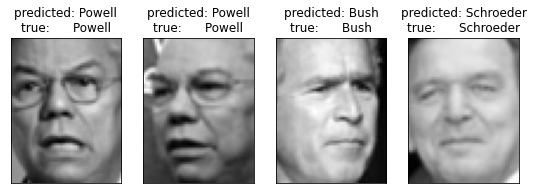

In [18]:
# printing images
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_images(X_test, prediction_titles, height, width)

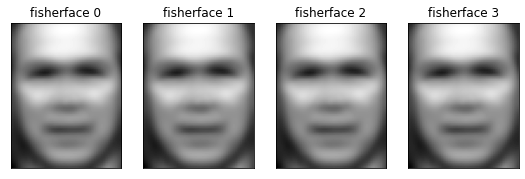

In [19]:
# plot fisherfaces
fisherface_titles = ["fisherface %d" % i for i in range(4)]
plot_images_lda(pca, lda, fisherface_titles, height, width)